# PyStruct - Structured Learning in Python #

PyStruct is structured learning and prediction library. It currently implements max-margin methods and supports different types of structures like chains or 2D grids.

## Installation ##

To install pystruct, you need cvxopt, cython and scikit-learn (which requires numpy and scipy).
The easiest way to install pystruct is using pip:

`pip install pystruct`

# Example: OCR Letter sequence recognition #

This example illustrates the use of a chain CRF for optical character recognition. The example is taken from Taskar et al. *Max-margin markov random fields*.

<ul>
    <li>Each example consists of a handwritten word, that was presegmented into characters. 
    <li>Each character is represented as a 16x8 binary image. 
    <li>The task is to classify the image into one of the 26 characters a-z. 
    <li>The first letter of every word was ommited as it was capitalized and the task does only consider small caps letters.
</ul>

We compare classification using:

<ul>
<li>a standard linear SVM that classifies each letter individually 
<li>a chain CRF that can exploit correlations between neighboring letters (the correlation is particularly strong as the same words are used during training and testing).
</ul>

There are obvious extensions that both methods could benefit from, such as window features or non-linear kernels. This example is more meant to give a demonstration of the CRF than to show its superiority.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC

from pystruct.datasets import load_letters
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

In [17]:
abc = "abcdefghijklmnopqrstuvwxyz"

letters = load_letters()
X, y, folds = letters['data'], letters['labels'], letters['folds']
# we convert the lists to object arrays, as that makes slicing much more convenient
X, y = np.array(X, dtype=object), np.array(y, dtype=object)
X_train, X_test = X[folds == 1], X[folds != 1]
y_train, y_test = y[folds == 1], y[folds != 1]

In [18]:
# Train linear SVM
svm = LinearSVC(dual=False, C=.1)
# flatten input
svm.fit(np.vstack(X_train), np.hstack(y_train))

LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [19]:
# Train linear chain CRF
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=11)
ssvm.fit(X_train, y_train)

FrankWolfeSSVM(C=0.1, batch_mode=False, check_dual_every=10, do_averaging=True,
               line_search=True, logger=None, max_iter=11,
               model=ChainCRF(n_states: 26, inference_method: max-product),
               n_jobs=1, random_state=None, sample_method='perm',
               show_loss_every=0, tol=0.001, verbose=0)

In [20]:
print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

print("Test score with linear SVM: %f" % svm.score(np.vstack(X_test),
                                                   np.hstack(y_test)))

Test score with chain CRF: 0.786754
Test score with linear SVM: 0.713791


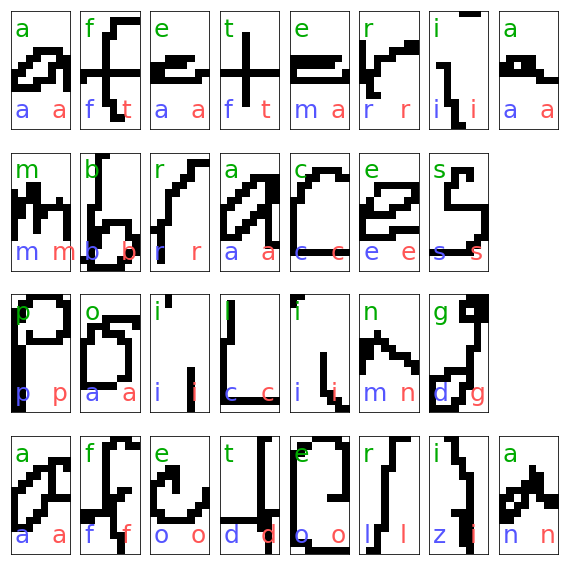

In [21]:
# plot some word sequenced
n_words = 4
rnd = np.random.RandomState(1)
selected = rnd.randint(len(y_test), size=n_words)
max_word_len = max([len(y_) for y_ in y_test[selected]])
fig, axes = plt.subplots(n_words, max_word_len, figsize=(10, 10))
fig.subplots_adjust(wspace=0)
for ind, axes_row in zip(selected, axes):
    y_pred_svm = svm.predict(X_test[ind])
    y_pred_chain = ssvm.predict([X_test[ind]])[0]
    for i, (a, image, y_true, y_svm, y_chain) in enumerate(
            zip(axes_row, X_test[ind], y_test[ind], y_pred_svm, y_pred_chain)):
        a.matshow(image.reshape(16, 8), cmap=plt.cm.Greys)
        a.text(0, 3, abc[y_true], color="#00AA00", size=25)
        a.text(0, 14, abc[y_svm], color="#5555FF", size=25)
        a.text(5, 14, abc[y_chain], color="#FF5555", size=25)
        a.set_xticks(())
        a.set_yticks(())
    for ii in range(i + 1, max_word_len):
        axes_row[ii].set_visible(False)

plt.show()

The figure shows the segmented letters of four words from the test set. In set are the ground truth (green), the prediction using SVM (blue) and the prediction using a chain CRF (red).

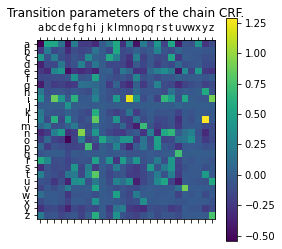

In [22]:
plt.matshow(ssvm.w[26 * 8 * 16:].reshape(26, 26))
plt.colorbar()
plt.title("Transition parameters of the chain CRF.")
plt.xticks(np.arange(26), abc)
plt.yticks(np.arange(26), abc)
plt.show()

The figure shows the pairwise potentials learned by the chain CRF. The strongest patterns are *y after l* and *n after i*.

There are obvious extensions that both methods could benefit from, such as window features or non-linear kernels. 